# Clyde Goodall 2021

# TODO list


*   Implement better way of calculating relative volume
*   Implement more plots/make current ones better looking
*   Add a method to filter through all available crypto and only chart crypto that have relative volume above a certain threshold








# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt

# Global constants

In [2]:

API_KEY = "get your own ;)"
VOL_COLUMN = "top_tier_volume_total"
SIZE = 400
RATIO = .95
TIME = 'time'

In [3]:
#list of crypto to actually fetch and compare, initially
watch_list = [
              'ETH', 'BTC', 'ADA', 'BNB', 'DOGE', 'XRP', 'DOT', 'UNI', 'LINK', 'CAKE', 'CRV'
]

#for charting when we get there
colors = [
          'blue', 'green', 'red', 'yellow'
]

# API calling and data assembly

In [4]:
#spits out daily volumes for a list of symbols
def get_and_format(list):
  data = []
  print("pulling data for {}".format(watch_list))
  
  for item in list:

    #pulls from cryptocompare, once for each entry iun watch_list, then converts to json, and produces a Dataframe for each top_tier_volume_total, should be 20 per. If it fails, print verbose exception
    try:
      req = requests.get(f'https://min-api.cryptocompare.com/data/symbol/histoday?fsym={item}&tsym=USD&limit={SIZE}&api_key={API_KEY}', headers={'Apikey': API_KEY})
    except Exception:
      print(Exception)

    #generates DataFrame
    predf = pd.read_json(json.dumps(req.json()['Data']))

    #selects only time and total volume
    df = pd.DataFrame(predf, columns=[TIME,VOL_COLUMN])
    df.rename(columns = {VOL_COLUMN : item}, inplace=True)

    #gets actual time out of unix timestamp, because that's the route they chose to go
    df['time'] = pd.to_datetime(df['time'],unit='s')
  
    #adds to array
    data.append(df)

    #suggcess message lmao
    print("data pulled for {}".format(item))
    
  print("Done :)")

  #returns dataframe array, once for each coin
  return data

  

# Calculations and plots

In [5]:
#calculates relative volume, using mean up to previous 24hrs, updating each iteration 
#(Would be slower than calc_relative_vol_historic)
def avg_rolling_vol(vol):

  #current idea: 
  #create temp np array. while the np array length is less than the set, 
  #have a counter that will average [:n] elements and append them to the temp array,
  #increasing by 1 per loop until the length == the dataframe size. 
  #Then replace the dataframe volume column with the numpy array
  #This should allow me to plot the entire swath of data without having to split between training/test
  #automating this will hopefully allow real-time updates that don't degrade in accuracy over time, compared to avg_vol()
  #Would hopefully produce data that could be meaningfully used in a TimeSeries model
  pass

#calculates relative volume, using a split in data
def avg_vol(vol):
  #calculates what portion to use to calculate the mean, and what to use for charting, in a train/test format, not unlike a neural net
   train_len = int(SIZE * RATIO)  #test_len is not necessary because in an array, test size is simply max length - train length

   #print("train len: {}".format(train_len))
   #print("Training on {} days of data".format(train_len))
   train_segment = vol[:train_len]
   #(train_segment)
   test_segment = vol[train_len:] 

   #split test_segment into two to make column operations easier
   test_segment_time = test_segment['time']
   test_segment_vol = test_segment.loc[:, test_segment.columns != 'time']

   #should yield mean
   avg = train_segment.iloc[:, train_segment.columns != 'time'].sum() / train_len 

   #relvative volume = (current volume / average volume)
   relative_vol = test_segment_vol / avg

   #inner joins  the time column and volume column after the relative calculation ^
   relative_vol_rejoin = pd.concat([test_segment_time, relative_vol], axis=1, join='inner')

   return relative_vol_rejoin


#plots relative volume
def plot_relative_vol(vol):
  #where all the relative volume dataframes go
  relative = []
  for entry in vol:
    relative.append(avg_vol(entry))

  fig, ax = plt.subplots(figsize=(12, 6))

  for entry in relative:
    sns.lineplot(
        x = TIME, 
        y = entry.columns[1], 
        data=entry[:-1])

  plt.legend(labels=watch_list, loc = 2, bbox_to_anchor = (1,1))
  plt.xlabel('Day')
  plt.ylabel('Relative Volume')
  plt.show()
  

#plots actual volume
def plot_vol(vol):
  fig, ax = plt.subplots(figsize=(12, 6))
  for entry in vol:
    sns.lineplot(
        x = TIME, 
        y = entry.columns[1], 
        data=entry[int(SIZE*RATIO):-1]
        )

  plt.legend(labels=watch_list, loc = 2, bbox_to_anchor = (1,1))
  plt.xlabel('Day')
  plt.ylabel('Total Volume')
  plt.show()


In [6]:
data = get_and_format(watch_list)

pulling data for ['ETH', 'BTC', 'ADA', 'BNB', 'DOGE', 'XRP', 'DOT', 'UNI', 'LINK', 'CAKE', 'CRV']
data pulled for ETH
data pulled for BTC
data pulled for ADA
data pulled for BNB
data pulled for DOGE
data pulled for XRP
data pulled for DOT
data pulled for UNI
data pulled for LINK
data pulled for CAKE
data pulled for CRV
Done :)


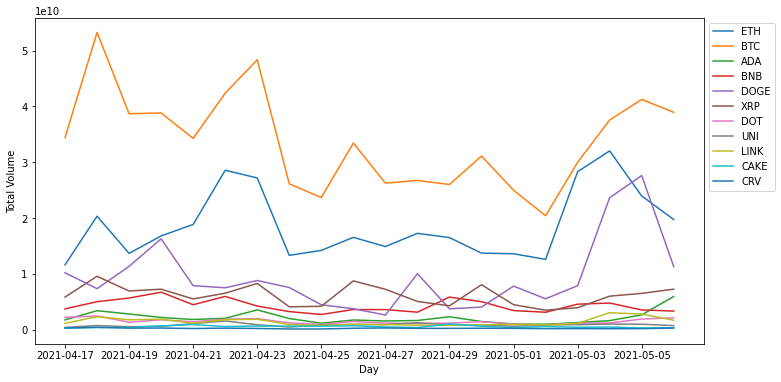

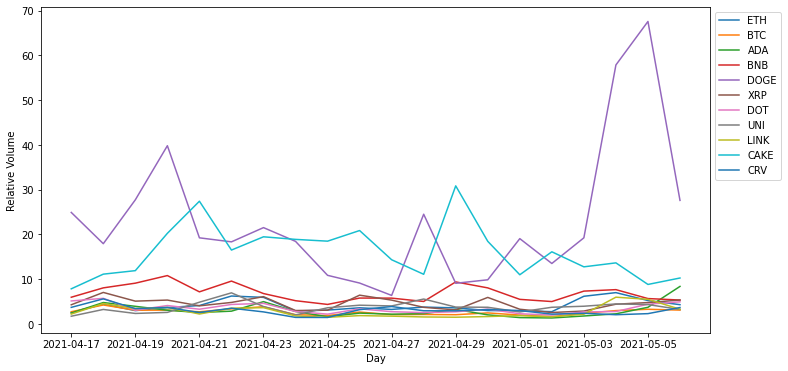

In [7]:
plot_vol(data)
plot_relative_vol(data)